##Import Libraries

In [ ]:
!pip install rasterio
!pip install -U tensorflow
!pip install -U keras

In [ ]:
!pip freeze

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [8]:
import tensorflow as tf
import cv2
import matplotlib
import os
import rasterio as rio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show, show_hist
from sklearn.model_selection import train_test_split
import keras
from rasterio import warp
from rasterio import merge

In [9]:
tifpath = "/content/drive/MyDrive/dataset/images/"
bmppath = "/content/drive/MyDrive/dataset/mask/"
bmpfol = []
tiffol=[]
for image in os.listdir(tifpath):
    tiffol.append(tifpath+image)
for _ in os.listdir(bmppath):
    bmpfol.append(bmppath+_)

tiffol = sorted(tiffol)
bmpfol = sorted(bmpfol)
print('Instances of Mask Dataset:',len(bmpfol))
print('\nInstances of Raster Image Dataset:',len(tiffol))

Instances of Mask Dataset: 352

Instances of Raster Image Dataset: 352


##Affine Transformation data (GeoTiff)

In [10]:
cols = ["A","B","C","D","E","F"]
affines = pd.DataFrame(columns=cols)

In [11]:
for i in tiffol:
  srt = rio.open(i)
  row = pd.DataFrame([srt.profile['transform'][0],srt.profile['transform'][1],srt.profile['transform'][2],srt.profile['transform'][3],srt.profile['transform'][4],srt.profile['transform'][5]]).T
  row.columns=cols
  affines = pd.concat([affines,row],ignore_index=True)

In [12]:
affines

A    B       C    D         E      F
0    0.013636  0.0 -102.00  0.0 -0.010831  39.50
1    0.012766  0.0  -86.60  0.0 -0.010909  30.70
2    0.013462  0.0  -96.70  0.0 -0.010870  36.80
3    0.012575  0.0  -95.50  0.0 -0.010823  31.90
4    0.012195  0.0  -98.60  0.0 -0.010843  27.60
..        ...  ...     ...  ...       ...    ...
347  0.013939  0.0 -119.20  0.0 -0.010909  38.80
348  0.012903  0.0  -83.70  0.0 -0.010870  33.75
349  0.012727  0.0  -89.48  0.0 -0.010829  33.55
350  0.013491  0.0 -119.28  0.0 -0.010833  37.20
351  0.013793  0.0 -119.80  0.0 -0.010855  38.67

[352 rows x 6 columns]

In [13]:
affines['B'].unique()

array([0.])

In [14]:
affines['D'].unique()

array([0.])

In [15]:
datasample = affines.iloc[28]
datasample

A      0.013333
B      0.000000
C   -111.600000
D      0.000000
E     -0.010909
F     34.900000
Name: 28, dtype: float64

In [16]:
thetransform = np.array([[datasample['A'],datasample['B'],datasample['C']],[datasample['D'],datasample['E'],datasample['F']]])
thetransform

array([[ 1.33333333e-02,  0.00000000e+00, -1.11600000e+02],
       [ 0.00000000e+00, -1.09090909e-02,  3.49000000e+01]])

In [17]:
print(srt.xy(0, 0))

(-119.79310344827586, 38.66457264957265)


In [18]:
srtsample = rio.open(tiffol[0])

##Visualization

In [19]:
plt.style.use('dark_background')

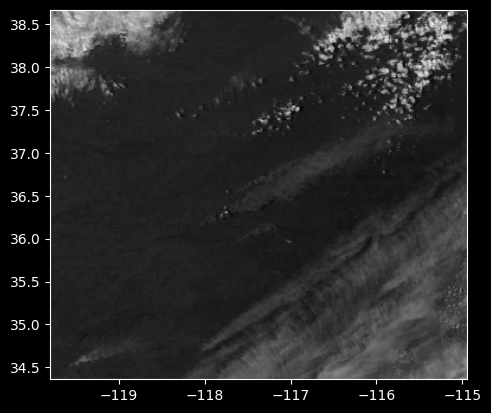

<Axes: >

In [20]:
rio.plot.show(srtsample.read(1),transform=srt.transform,cmap="gray")

In [21]:
rio.open(tiffol[0]).read(1)

array([[118, 119, 111, ..., 133, 124, 124],
       [122, 121, 114, ..., 113, 116, 102],
       [123, 121, 116, ...,  90,  86,  91],
       ...,
       [ 77,  77,  76, ..., 111, 113, 116],
       [ 77,  76,  75, ..., 121, 119, 118],
       [ 76,  77,  77, ..., 123, 121, 117]], dtype=uint8)

In [22]:
wgstifpath="/content/drive/MyDrive/wgs84/"
dst_crs = 'EPSG:4326'
for i in os.listdir(tifpath):
  with rio.open(tifpath+i) as src:
      transform, width, height = warp.calculate_default_transform(
          src.crs, dst_crs, src.width, src.height, *src.bounds)
      kwargs = src.meta.copy()
      kwargs.update({
          'crs': dst_crs,
          'transform': transform,
          'width': width,
          'height': height
      })

      with rio.open(wgstifpath+i, 'w', **kwargs) as dst:
          for j in range(1, src.count + 1):
              warp.reproject(
                  source=rio.band(src, j),
                  destination=rio.band(dst, j),
                  src_transform=src.transform,
                  src_crs=src.crs,
                  dst_transform=transform,
                  dst_crs=dst_crs,
                  resampling=warp.Resampling.nearest)

In [23]:
rio.open("/content/drive/MyDrive/wgs84/time-20170652036101-loc--102.0_35.2_-97.2_39.5.tif").xy(0,0)

(-101.99392702151664, 39.49392702151663)

In [24]:
rio.open("/content/drive/MyDrive/wgs84/time-20170652036101-loc--102.0_35.2_-97.2_39.5.tif").transform

Affine(0.012145956966727253, 0.0, -102.0,
       0.0, -0.012145956966727253, 39.5)

In [25]:
wgstifs = sorted(os.listdir(wgstifpath))

In [26]:
wgssample = rio.open(wgstifpath+wgstifs[0])

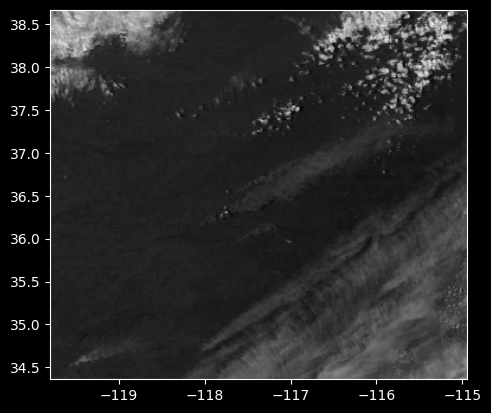

In [27]:
rio.plot.show(srtsample.read(1),transform=srt.transform,cmap="gray")
plt.show()

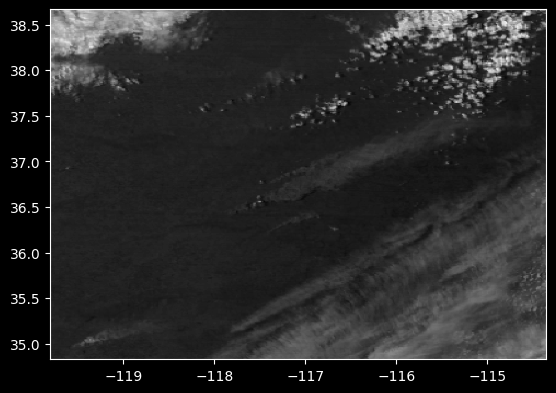

In [28]:
rio.plot.show(wgssample.read(1),transform=srt.transform,cmap="gray")
plt.show()

In [29]:
srt2= rio.open(tiffol[28])

In [30]:
wgs2 = rio.open(wgstifpath+wgstifs[28])

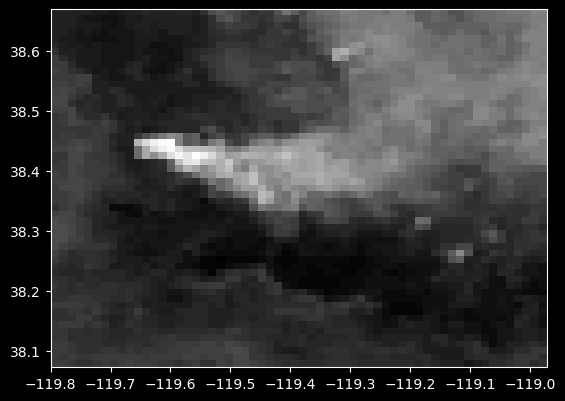

In [31]:
rio.plot.show(srt2.read(1),transform=srt.transform,cmap="gray")
plt.show()

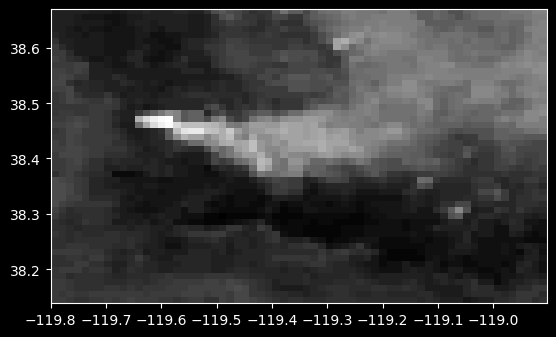

In [32]:
rio.plot.show(wgs2.read(1),transform=srt.transform,cmap="gray")
plt.show()

##Mosaicking

In [33]:
stuff_to_mosaic=[]
for i in os.listdir(tifpath):
  srt = rio.open(wgstifpath+i)
  stuff_to_mosaic.append(srt)

In [34]:
mosaic,out_trans = merge.merge(stuff_to_mosaic)

In [35]:
mosaic.shape

(6, 3813, 10206)

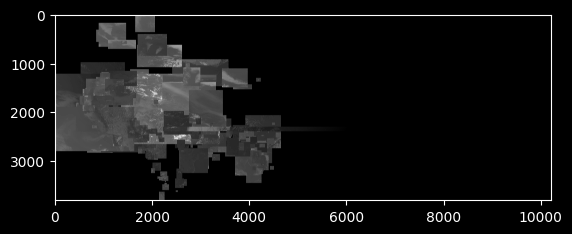

<Axes: >

In [36]:
show(mosaic[0],cmap="gray")

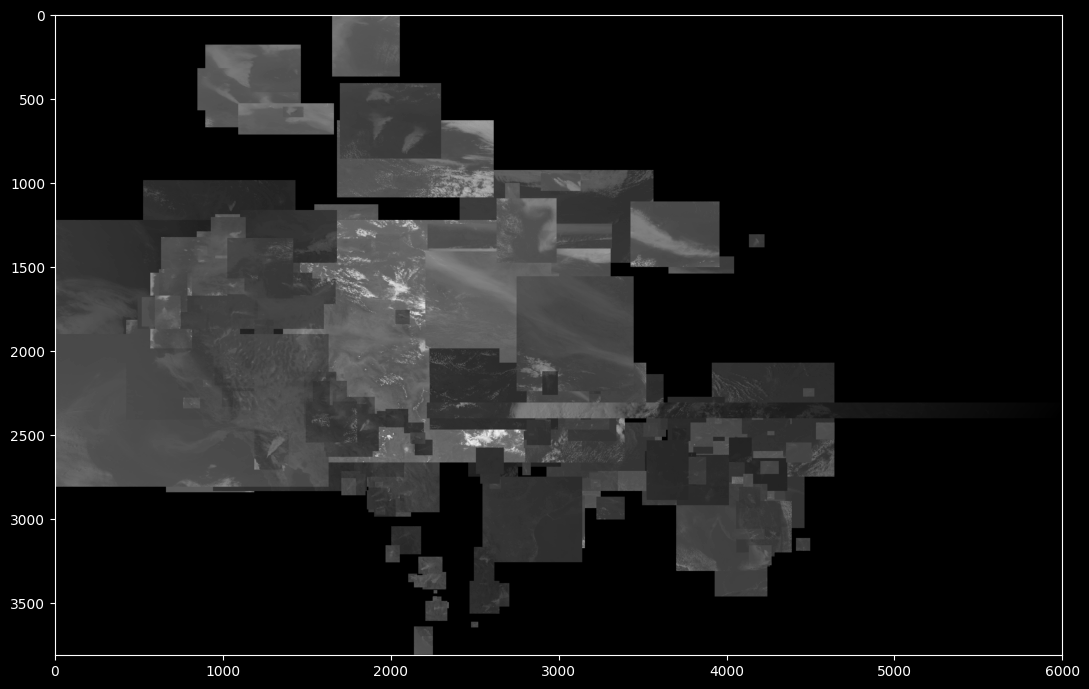

In [37]:
plt.figure(figsize=(13,18))
plt.imshow(mosaic[0],cmap="gray")
plt.xlim(0,6000)
plt.show()

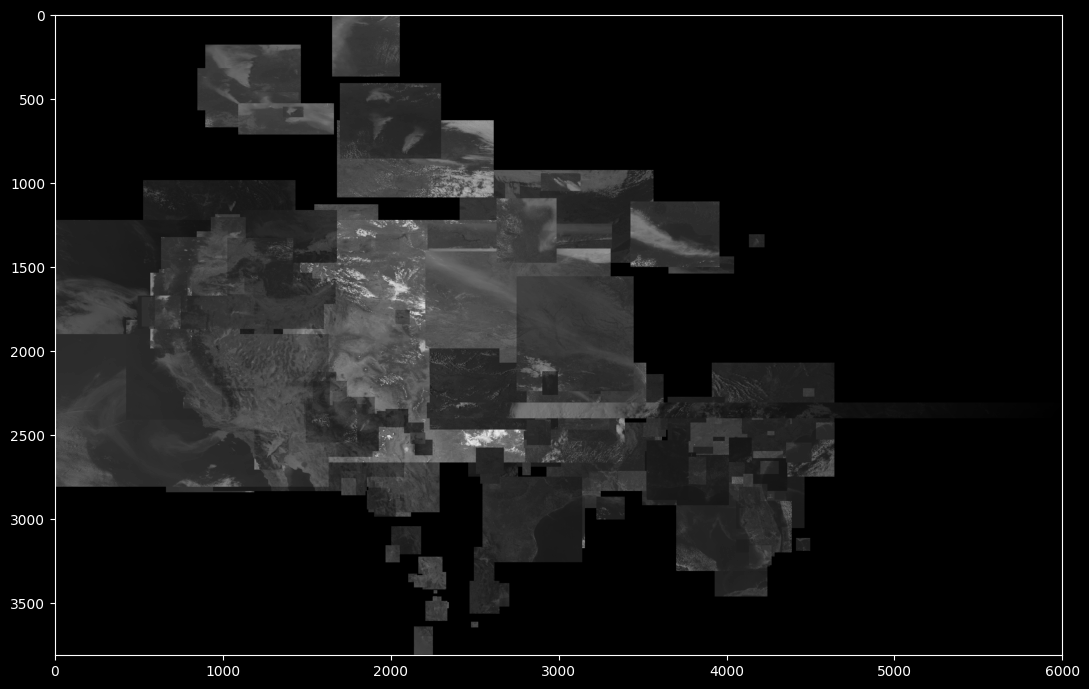

In [38]:
plt.figure(figsize=(13,18))
plt.imshow(mosaic[1],cmap="gray")
plt.xlim(0,6000)
plt.show()

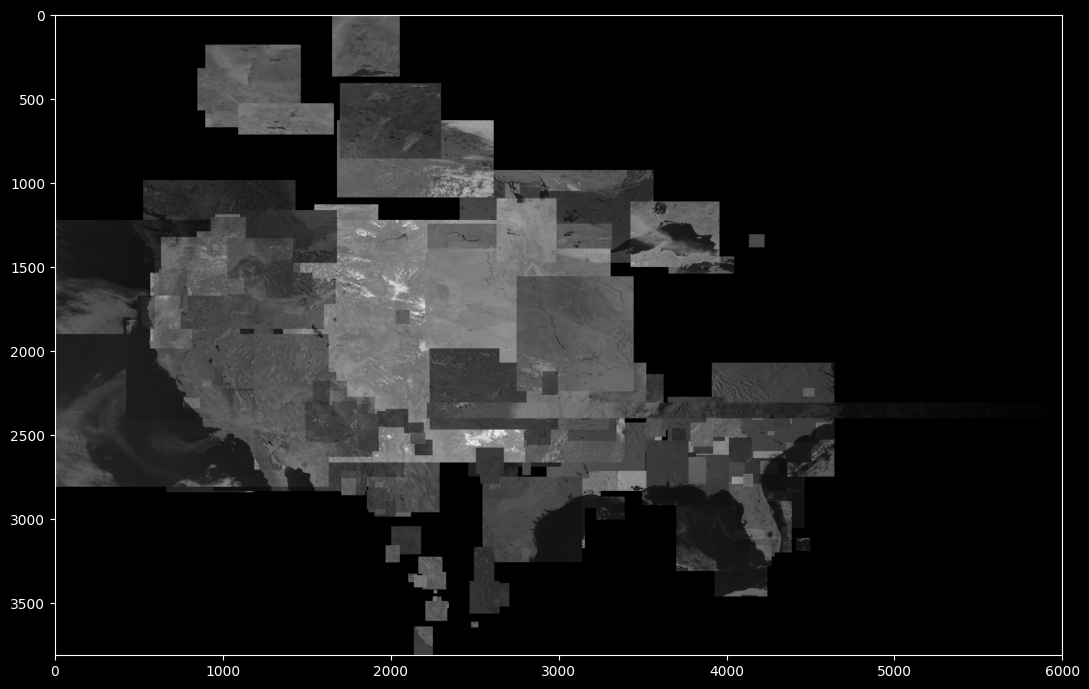

In [39]:
plt.figure(figsize=(13,18))
plt.imshow(mosaic[2],cmap="gray")
plt.xlim(0,6000)
plt.show()

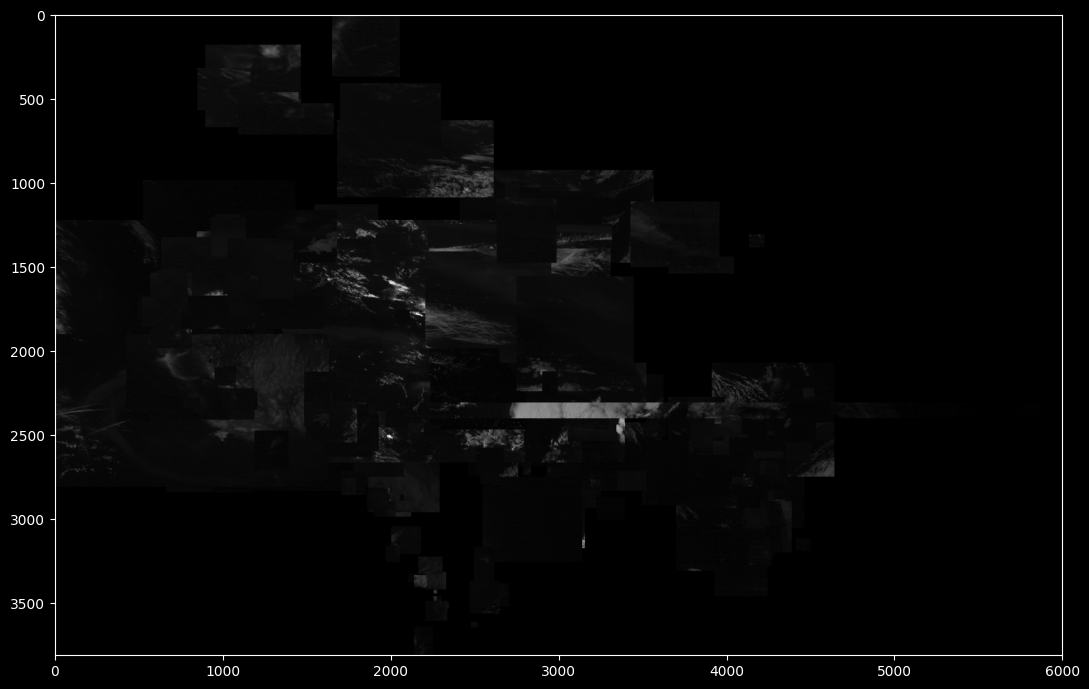

In [40]:
plt.figure(figsize=(13,18))
plt.imshow(mosaic[3],cmap="gray")
plt.xlim(0,6000)
plt.show()

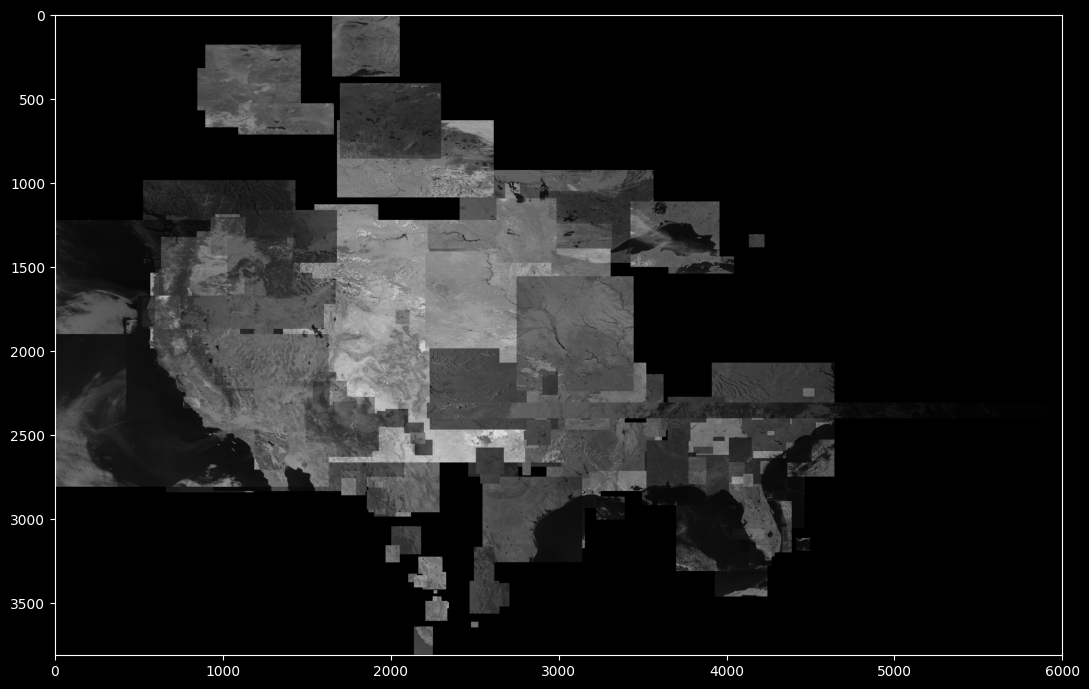

In [41]:
plt.figure(figsize=(13,18))
plt.imshow(mosaic[4],cmap="gray")
plt.xlim(0,6000)
plt.show()

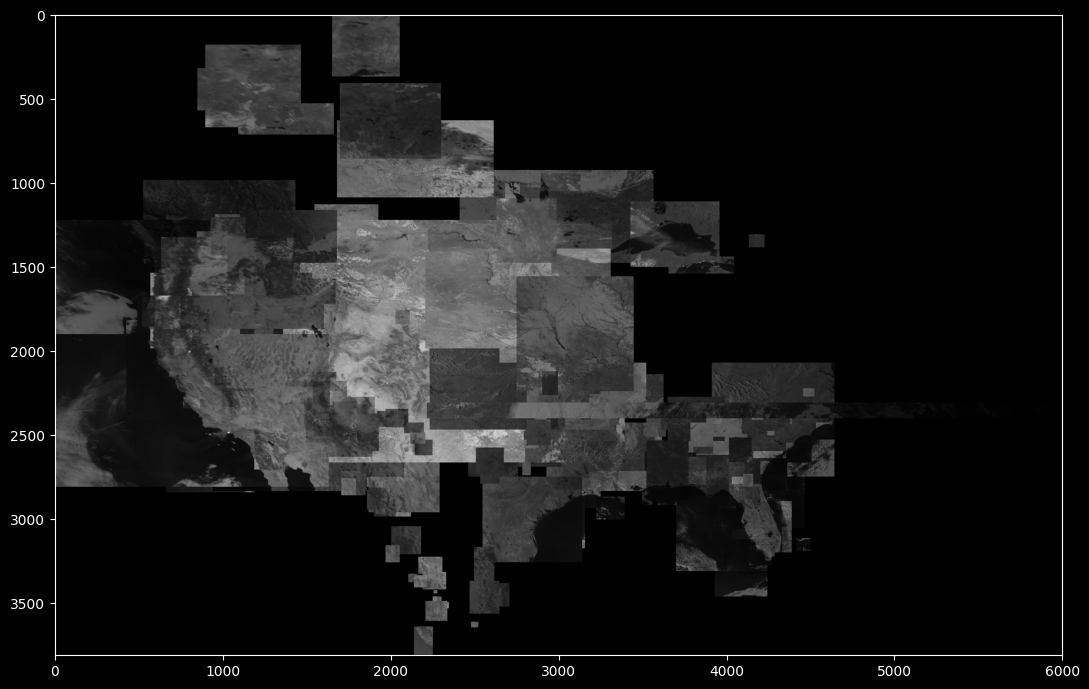

In [42]:
plt.figure(figsize=(13,18))
plt.imshow(mosaic[5],cmap="gray")
plt.xlim(0,6000)
plt.show()

##Redundant Image removal

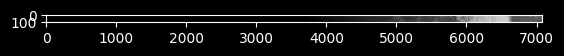

In [43]:
plt.imshow(rio.open(tifpath + sorted(os.listdir(tifpath))[293]).read(1),cmap="gray")
plt.show()

In [44]:
cleaned_mosaic_stuff = []
wgstifs = sorted(wgstifs)
redundant = wgstifs[293]

In [45]:
cleaned_tifpath = sorted([wgstifpath+i for i in wgstifs])
cleaned_tifpath.remove(wgstifpath+redundant)

In [46]:
len(cleaned_tifpath)

351

###Cleaned GeoTIFF Mosaic

In [47]:
for i in cleaned_tifpath:
  srt = rio.open(i)
  cleaned_mosaic_stuff.append(srt)

In [48]:
cleaned_mosaic,cleanout_trans = merge.merge(cleaned_mosaic_stuff)

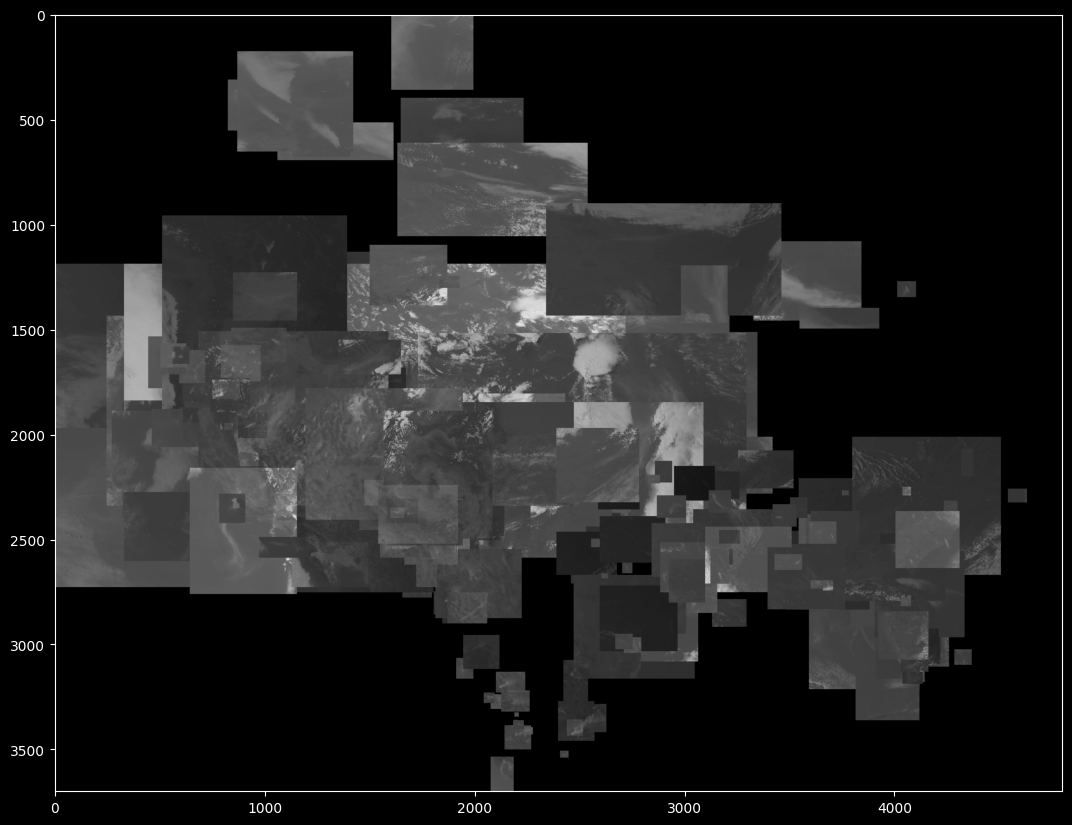

In [49]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[0],cmap="gray")
plt.xlim(0,4800)
plt.show()

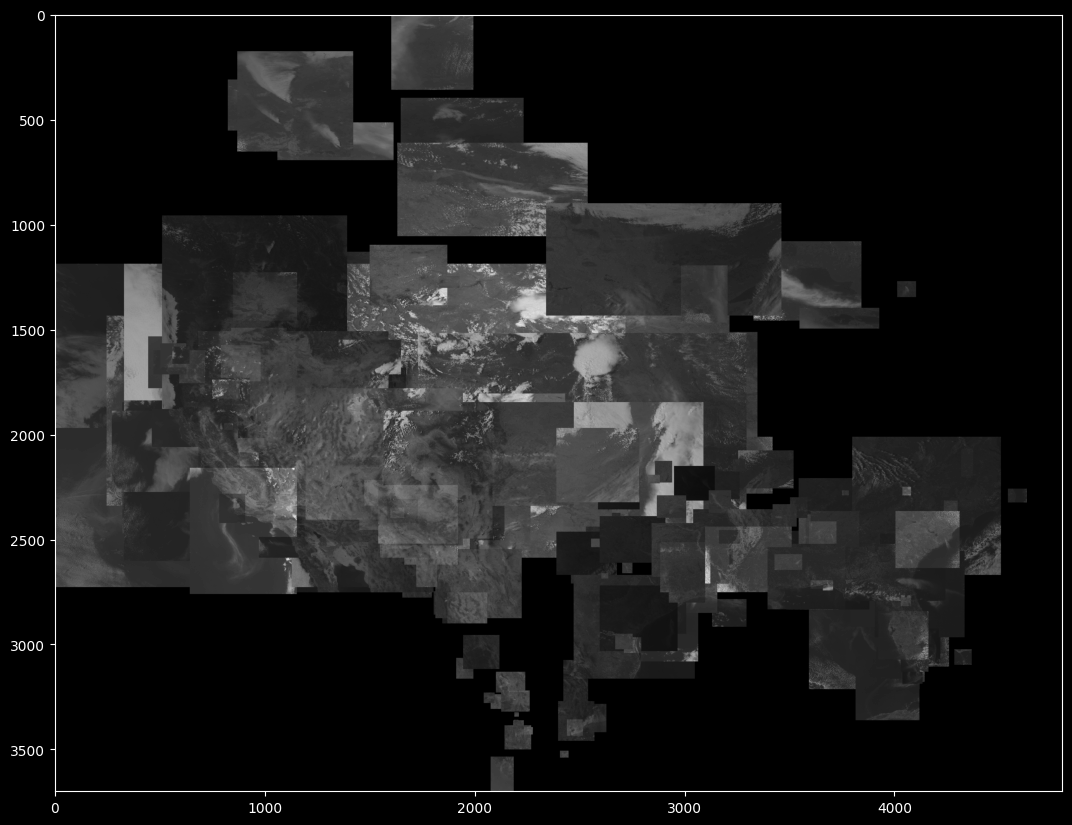

In [50]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[1],cmap="gray")
plt.xlim(0,4800)
plt.show()

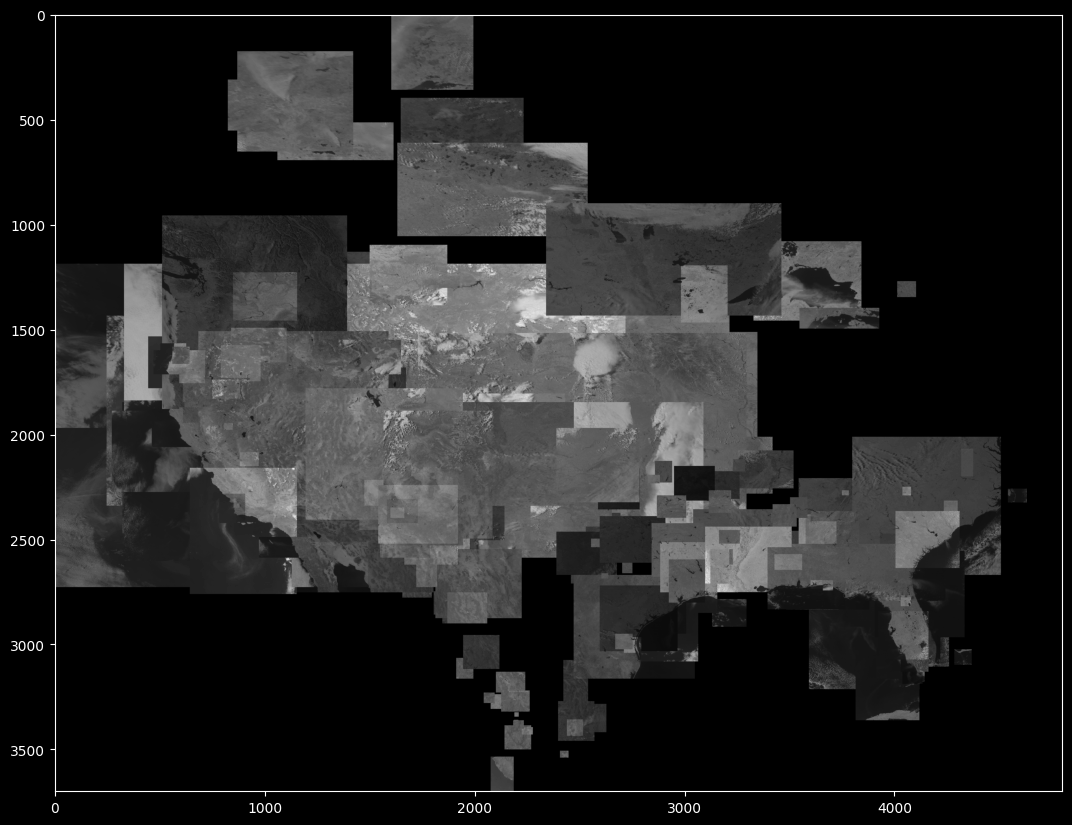

In [51]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[2],cmap="gray")
plt.xlim(0,4800)
plt.show()

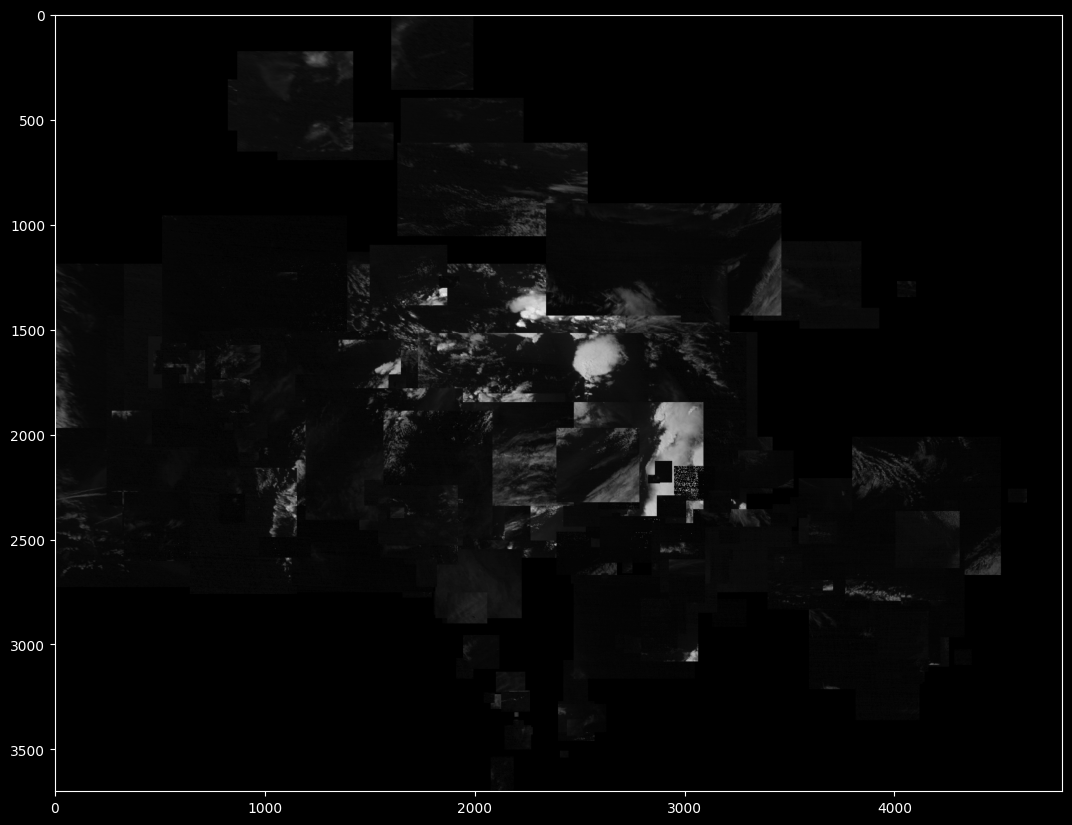

In [52]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[3],cmap="gray")
plt.xlim(0,4800)
plt.show()

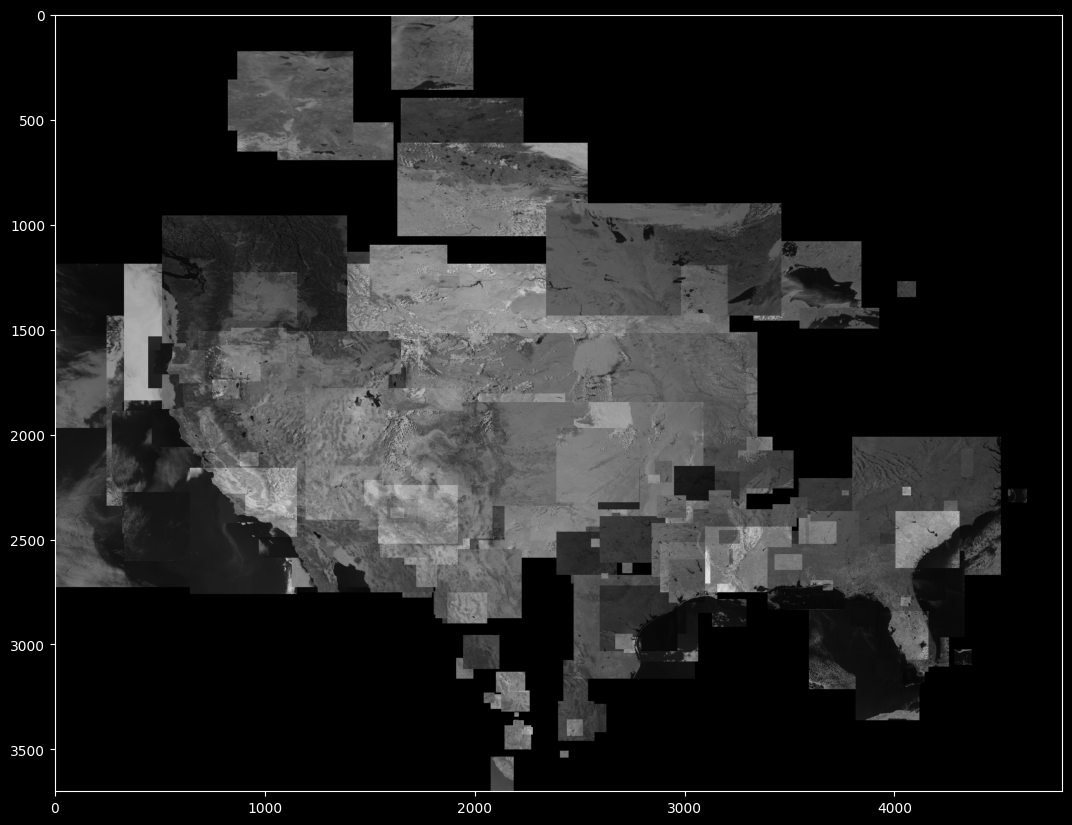

In [53]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[4],cmap="gray")
plt.xlim(0,4800)
plt.show()

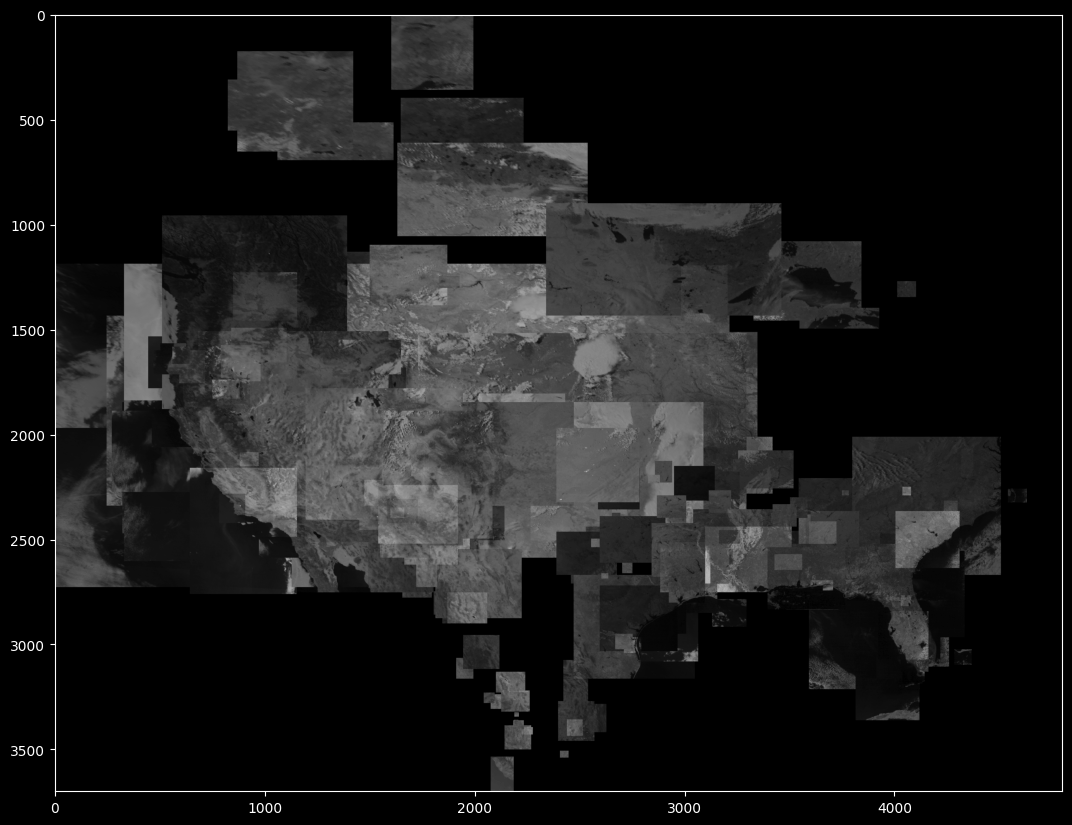

In [54]:
plt.figure(figsize=(13,18))
plt.imshow(cleaned_mosaic[5],cmap="gray")
plt.xlim(0,4800)
plt.show()

##Affine Transformation data (Bitmap)

In [55]:
wgsbmppath = "/content/drive/MyDrive/wgs84mask/"
cleaned_wgsbmps = os.listdir("/content/drive/MyDrive/dataset/mask/")
cleaned_wgsbmps.remove(cleaned_wgsbmps[293])
cleaned_wgsbmps = [wgsbmppath + i for i in cleaned_wgsbmps]

In [56]:
cleaned_bmps = sorted(os.listdir(bmppath))
redundant = cleaned_bmps[293]
redundant

'time-20191742310594-loc--10.7_35.1_-104.9_36.2.bmp'

In [57]:
cleaned_bmps.remove(redundant)

In [58]:
bitmap_mosaic_stuff=[]
for i in cleaned_bmps:
  srb = rio.open(bmppath+i)
  bitmap_mosaic_stuff.append(srb)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [69]:
cols = ["A","B","C","D","E","F"]
bmpaffines = pd.DataFrame(columns=cols)

In [70]:
for i in bitmap_mosaic_stuff:
  row = pd.DataFrame([i.profile['transform'][0],i.profile['transform'][1],i.profile['transform'][2],i.profile['transform'][3],i.profile['transform'][4],i.profile['transform'][5]]).T
  row.columns=cols
  bmpaffines = pd.concat([bmpaffines,row],ignore_index=True)

In [71]:
bmpaffines

A    B    C    D    E    F
0    1.0  0.0  0.0  0.0  1.0  0.0
1    1.0  0.0  0.0  0.0  1.0  0.0
2    1.0  0.0  0.0  0.0  1.0  0.0
3    1.0  0.0  0.0  0.0  1.0  0.0
4    1.0  0.0  0.0  0.0  1.0  0.0
..   ...  ...  ...  ...  ...  ...
346  1.0  0.0  0.0  0.0  1.0  0.0
347  1.0  0.0  0.0  0.0  1.0  0.0
348  1.0  0.0  0.0  0.0  1.0  0.0
349  1.0  0.0  0.0  0.0  1.0  0.0
350  1.0  0.0  0.0  0.0  1.0  0.0

[351 rows x 6 columns]

In [73]:
affines.head(1)

A    B      C    D         E     F
0  0.013636  0.0 -102.0  0.0 -0.010831  39.5

In [74]:
def change_affine_transformation(image, affine_transformation, crs):
    """Changes the affine transformation of an image.

    Args:
        image (str): The path to the image.
        affine_transformation (list): The new affine transformation.
        crs (str): The new coordinate reference system.

    Returns:
        None
    """

    image = gdal.Open(image)
    image.SetGeoTransform(affine_transformation)
    image.SetProjection(crs)

    image.FlushCache()